# Import Packages

In [6]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser

# Import & Process Data

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [9]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning
# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

In [10]:
print(filtered_data.shape)
filtered_data.head()

(20307, 16)


_id                 accountId  \
0  6220c8e159378700114a8722  61c5e725941a0600135559cf   
1  62c30db86daa10001266325e  6215fbb82c463a001166ad8f   
2  62e0fcf555577b00112d3176  625e873608ff4300110c62af   
4  62c44ba62e447d00129fc612  61c453eebcc5e4001133f68a   
5  62c5589f756f3f00119ec3b4  61c453eebcc5e4001133f68a   

                             customerId IMD_Decile                 createdAt  \
0  4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8          9  2022-03-03T13:55:45.434Z   
1  a4c47159-e445-4b31-8ea9-6c5852bd7095          8  2022-07-04T15:56:40.950Z   
2  b5a28615-7994-458e-8903-8086ac77eb49  Not_Found  2022-07-27T08:53:09.433Z   
4  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-05T14:33:10.080Z   
5  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-06T09:40:47.483Z   

  amount.currency  amount.exponent  amount.value  \
0             GBP                2          5067   
1             GBP                2          4600   
2             GBP                2          5000   
4             GBP                2           600   
5             GBP                2           600   

   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 742                             OTHER   
2                                 742                             OTHER   
4                                1520                          SHOPPING   
5                                1520                          SHOPPING   

                                  MCC_List  \
0                      Veterinary Services   
1                      Veterinary Services   
2                      Veterinary Services   
4  General Contractor/Residential Building   
5  General Contractor/Residential Building   

   transactionFootPrint.carbonEmissionInGrams transactionType.code  \
0                                10048.033278           REDEMPTION   
1                                 9121.956400           REDEMPTION   
2                                 9915.170000           REDEMPTION   
4                                15224.930000           REDEMPTION   
5                                15224.930000           REDEMPTION   

  transactionType.direction  emission_rate     mcc_classification  
0                     DEBIT       1.944456  Agricultural Services  
1                     DEBIT       1.983033  Agricultural Services  
2                     DEBIT       1.983034  Agricultural Services  
4                     DEBIT      25.374883    Contracted Services  
5                     DEBIT      25.374883    Contracted Services

In [6]:
print('nunique customerId: '+str(filtered_data['customerId'].nunique()))
print('nunique mcc_code: '+str(filtered_data['externalParty.merchantCategoryCode'].nunique()))
print('nunique mcc_code: '+str(filtered_data['MCC_List'].nunique()))

nunique customerId: 369
nunique mcc_code: 199
nunique mcc_code: 199


In [7]:
# Create the CustomerID array
CustomerID = list(customer_mcc_dict.keys())

# Create the MCC array by zipping the two lists together
MCC = [customer_mcc_dict[customer_id] for customer_id in CustomerID]

# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))
print(len(CustomerID))

369


In [8]:
# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))

if are_all_unique:
    print("All values in CustomerID are unique.")
else:
    print("There are duplicate values in CustomerID.")

All values in CustomerID are unique.


Check if the code does what we expect it to -- put a random value for a customer in i_doc and check if the list of MCC we get back is the same one as in the Excel file. Code works!

In [9]:
#Check for a random customer/MCC in Excel to make sure it is correct
i_doc = 102
print(CustomerID[i_doc])
print(MCC[i_doc][:10])

dcd7e7f0-3aea-4105-88c7-08f6f71413e9
['Local and Suburban Commuter Passenger Transportation, including Ferries', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets']


# Create Model and Plot

In [11]:
## Create the sbmtm model
model = sbmtm()

## we have to create the customer-MCC network from the data
model.make_graph(MCC,documents=CustomerID,counts=True)

model.g

<Graph object, undirected, with 568 vertices and 4322 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f5318be5610>

In [12]:
SEED = 41
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results

#fit the model
model.fit(n_init=100, verbose=False)

print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)

22317.39195333731
22772.265047997957
22411.47244741943
22431.5540366436
22421.583121145868
22288.642935194188
22362.049265347636
22600.427729176903
22592.17901558786
22319.091405546234
22405.837393822858
22542.032038998255
22470.23463750408
22272.33157544056
22384.396674070013
22383.270335588062
22343.052577725604
22592.561223887784
22393.46631198014
22297.734479090497
22409.728737154757
22609.499517106193
22466.57175686248
22498.27603658083
22389.219227746955
22554.139109376214
22328.77604066317
22285.019774324006
22339.77104615454
22413.758880071135
22753.426211317936
22463.29216825876
22194.887863136337
22391.491372066397
22256.762294919423
22489.36803316109
22204.92337286094
22488.78455123673
22357.740264833486
22356.809244631582
22407.707034391766
22451.28876683674
22513.698119347377
22547.82785354964
22442.053944861556
22324.619696215173
22294.69090356532
22768.18855395871
22665.738393994463
22526.281303943033
22449.12481132435
22344.3465942544
22441.4081708101
22241.16582784126


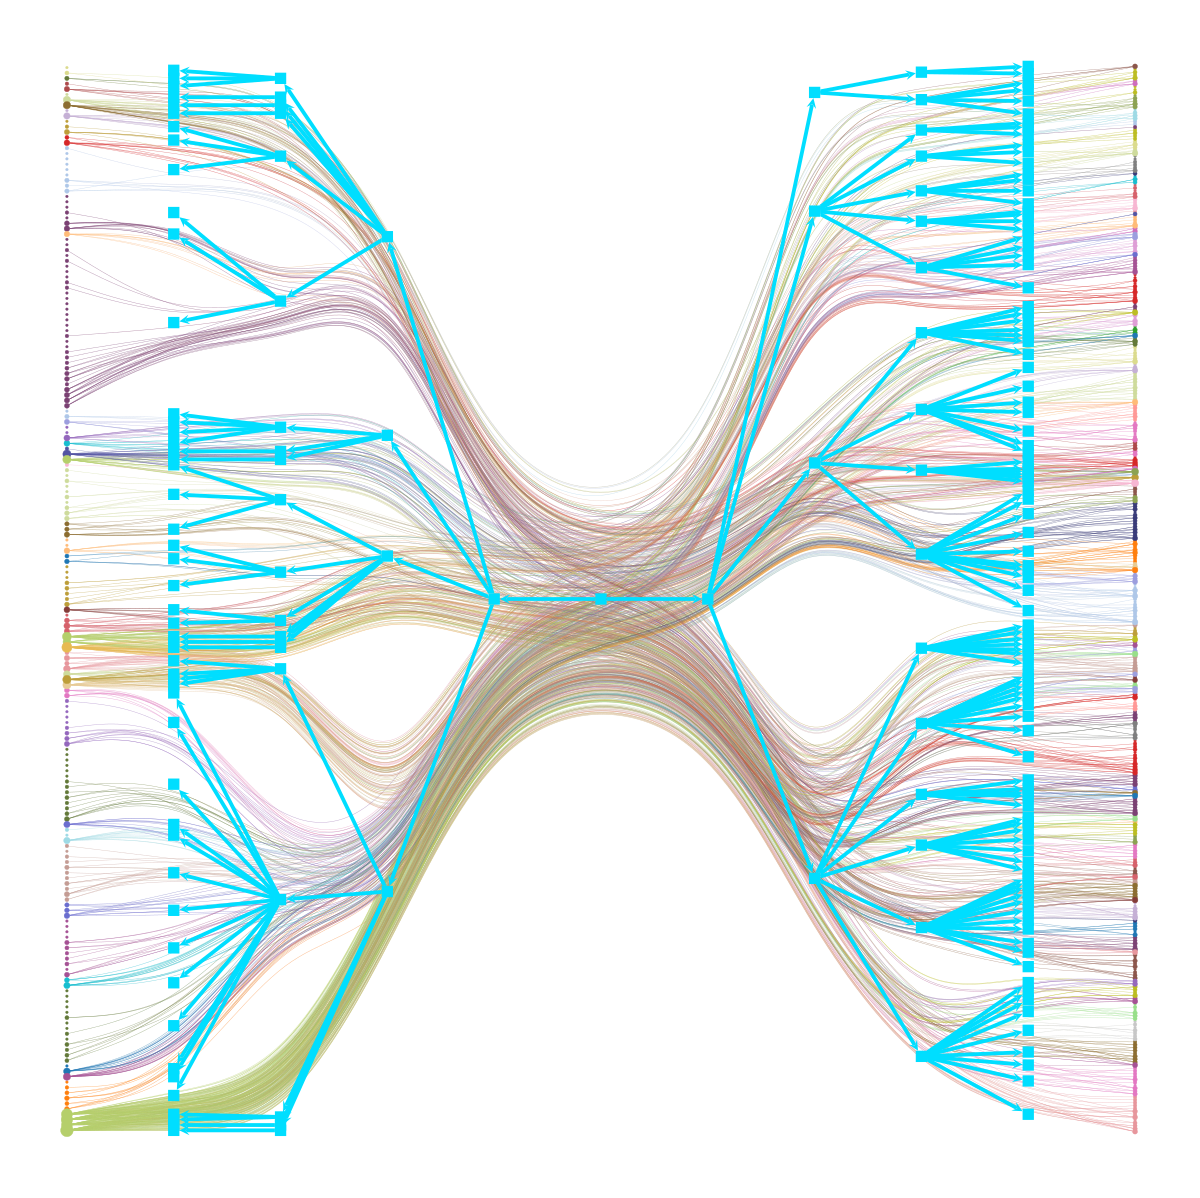

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5318be5610, at 0x7f5316b30140>,
 <GraphView object, directed, with 769 vertices and 768 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f5314f8b1d0, at 0x7f5314f8a420>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f5314f8b1d0, at 0x7f5314f8a8a0>, False), at 0x7f5314f8b1d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5314f8b1d0, at 0x7f53e0e70a70>)

In [23]:
#Plot
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [24]:
with open("./Results/minimized_model_seed_{}.pkl".format(SEED), "rb") as f:
        model_100 = pickle.load(f)
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 153 blocks at level 0, 37 at level 1, and its entropy is entropy: 22194.89


further sweep with the multiflip_mcmc just in case we got stuck in a bad local minimum

In [25]:
starting_entropy=model_100.state.entropy()
entropy_gain_multiflip=[model_100.state.multiflip_mcmc_sweep(beta=np.inf, niter=10)[0] for i in range(1000)]

In [30]:
model_100.state.entropy()

21283.50353176543

In [32]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff
# entropy_exp_10 = entropy_diff_positive/(np.log(2)+np.log(5))
# entropy_likelihood = np.power(10,entropy_exp_10)

In [61]:
with open('./Results/entropy_likelihood.pkl','wb') as f:
    pickle.dump(entropy_likelihood,f)

In [62]:
with open('./Results/multiflip_mcmc_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model_100,f)

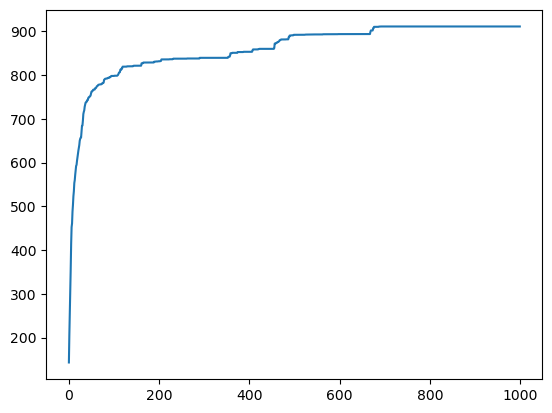

In [39]:
plt.plot(entropy_diff_positive)

clustering result after MCMC

In [40]:
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 165 blocks at level 0, 43 at level 1, and its entropy is entropy: 21283.50


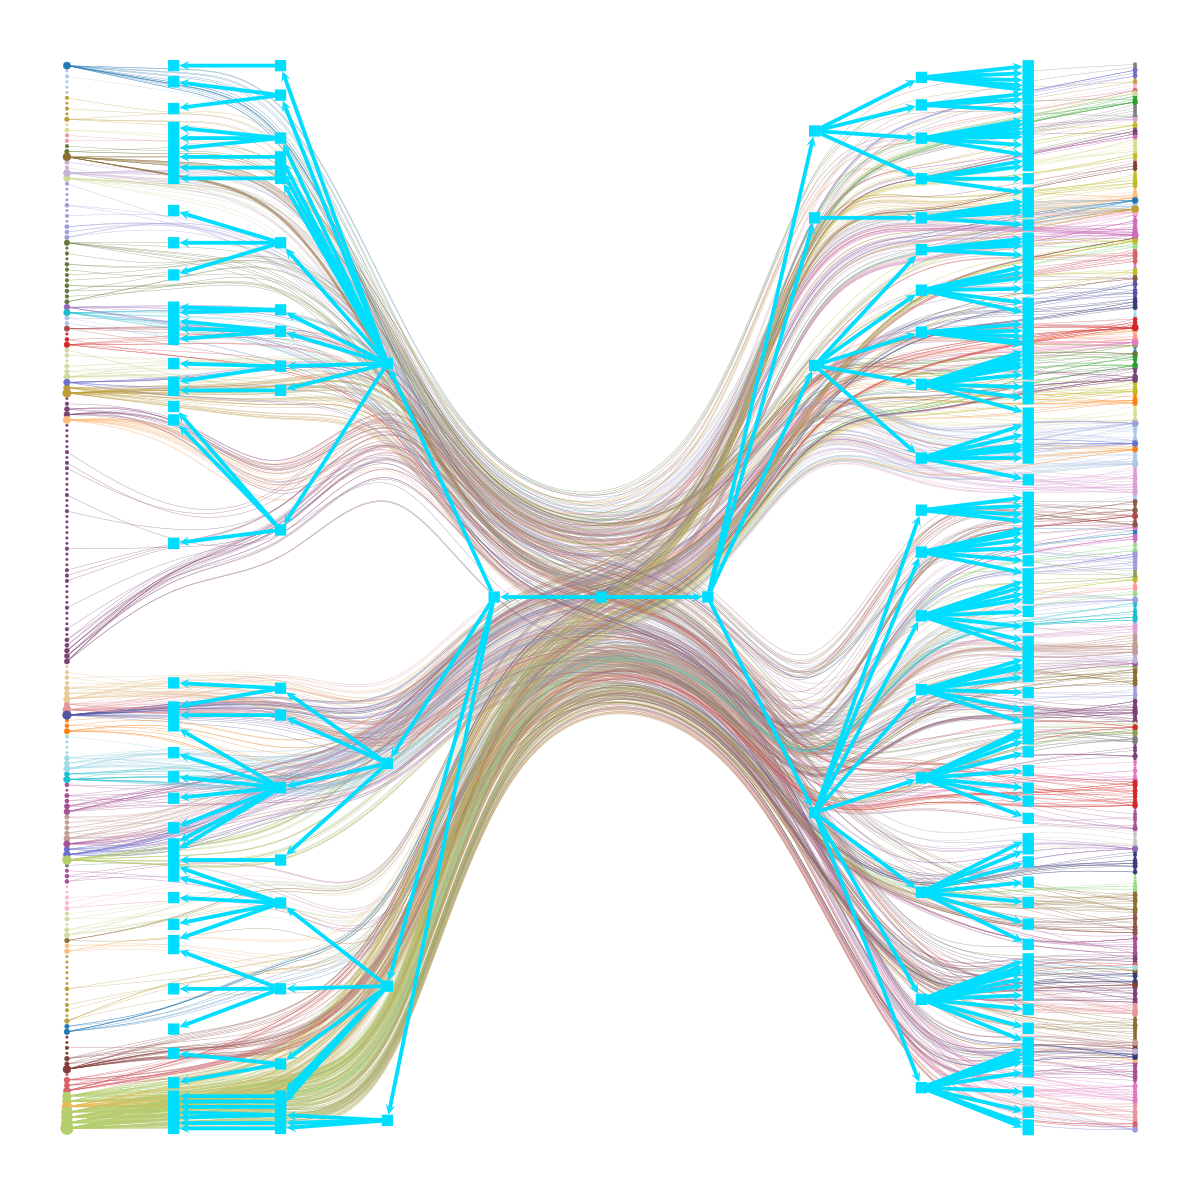

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5319443a10, at 0x7f5318e6aab0>,
 <GraphView object, directed, with 787 vertices and 786 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f53152399d0, at 0x7f531523bce0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f53152399d0, at 0x7f531523ad50>, False), at 0x7f53152399d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f53152399d0, at 0x7f531b27b950>)

In [41]:
#Plot
model_100.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [42]:
# get the cluster at different levels
levels = model_100.state.get_levels()
for i in range(3):
    print('Level',i)
    print('The lowest entropy was {}, and the state has {} blocks at level {}'.format(levels[i].entropy(),levels[i].get_nonempty_B(),i))
    print('The number of edges between blocks is {}'.format(levels[i].get_matrix().nnz))
    print('The number of edges within blocks is {}'.format(levels[i].get_matrix().sum()))

Level 0
The lowest entropy was 34545.32959823603, and the state has 165 blocks at level 0
The number of edges between blocks is 4608
The number of edges within blocks is 40648.0
Level 1
The lowest entropy was 18482.40471602379, and the state has 43 blocks at level 1
The number of edges between blocks is 796
The number of edges within blocks is 40648.0
Level 2
The lowest entropy was 9514.047933447186, and the state has 8 blocks at level 2
The number of edges between blocks is 32
The number of edges within blocks is 40648.0


In [45]:
model_100.get_groups(l=1)

{'Bd': 18,
 'Bw': 25,
 'p_tw_w': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'p_td_d': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 'p_w_tw': array([[0.00307062, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01428571, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.01120448,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0. 

In [50]:
len(model_100.clusters(l=1))

18

In [48]:
# get the number of documents in each topic(cluster) at level 1
# model.clusters(l=1)
# print the number of documents in each topic(cluster) at level 1
x = 0
for i in range(len(model_100.clusters(l=1))):
    x += len(model_100.clusters(l=1,n=100)[i])
    print('The number of documents in topic {} is {}'.format(i+1,len(model_100.clusters(l=1,n=100)[i])))
print('The total number of documents is {}'.format(x))

The number of documents in topic 1 is 30
The number of documents in topic 2 is 13
The number of documents in topic 3 is 31
The number of documents in topic 4 is 10
The number of documents in topic 5 is 18
The number of documents in topic 6 is 36
The number of documents in topic 7 is 25
The number of documents in topic 8 is 14
The number of documents in topic 9 is 43
The number of documents in topic 10 is 14
The number of documents in topic 11 is 11
The number of documents in topic 12 is 25
The number of documents in topic 13 is 26
The number of documents in topic 14 is 10
The number of documents in topic 15 is 26
The number of documents in topic 16 is 19
The number of documents in topic 17 is 9
The number of documents in topic 18 is 9
The total number of documents is 369


<Axes: >

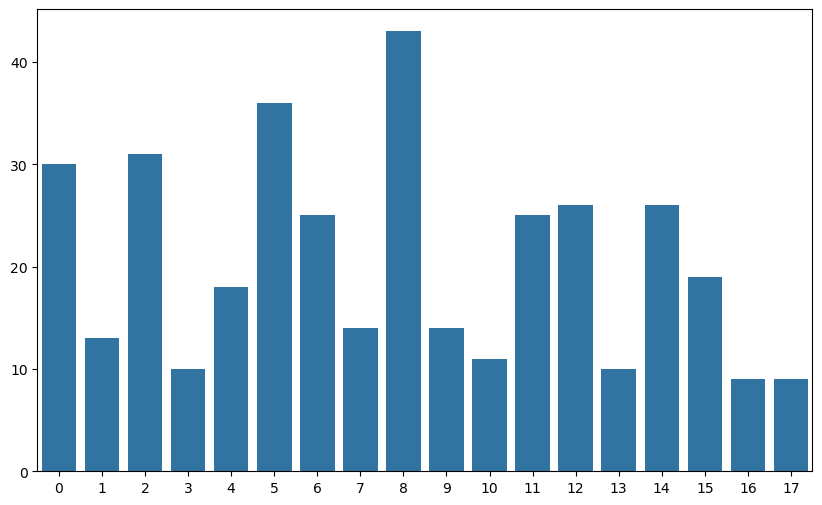

In [51]:
# plot the number of documents in each topic(cluster) at level 1, labeled by the topic(cluster) number
plt.figure(figsize=(10,6))
sns.barplot([len(model_100.clusters(l=1,n=100)[i]) for i in range(len(model_100.clusters(l=1)))])

# Model Analysis

In [238]:
Customer_clusters = model_100.clusters(l=1,n=1000).items()
Customer_clusters = [[id for id, p in cluster] for i, cluster in Customer_clusters]
Customer_clusters

[['4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8',
  '81773718-8d2a-4c67-823e-19544e4ae395',
  '2c26e6f7-b19d-4974-8052-8ee4ff93cda9',
  'd7ee236c-7eeb-4020-bd04-613093ab9217',
  '47099af3-f16e-4607-9a6a-6723185c88fd',
  '7869e5f9-f5d7-469e-9afa-3e91b7d69377',
  '2b0da8b4-4a4e-4398-bcc8-c5044bcd3e1c',
  'bae5dffb-f840-4b05-843a-b1a1e50bf98e',
  '886234ca-f3b0-43dc-b4fc-050c3f364682',
  'd832458b-a766-422f-a8d7-df9cfe5588fb',
  'ea6203f6-d3a9-4218-85a6-8e1338e17e09',
  '55203a37-2196-40d6-90f6-19b3be2e1eae',
  'dcd7e7f0-3aea-4105-88c7-08f6f71413e9',
  '878a2bdf-a03e-4a90-99f7-cc562b2596a8',
  '6d1fd2c3-96ee-4e59-8c43-8748aba92678',
  'a926714a-3061-4fe5-a890-c96c302b4dff',
  '187bd84b-20c7-45c7-8044-0fdb586e28a1',
  '0c922076-e434-411a-8a3e-1c06b00979f4',
  '1abbb4da-f42b-473b-847a-52bfabcd4db1',
  '72a0cb8b-f9d3-40a9-a54d-00931a871fde',
  'af7c2018-56a5-4338-afb4-25e35fe2f427',
  '1563db62-ffd6-4506-a744-7d505858216f',
  'c22cab43-3233-4fef-9548-561f03b4bb74',
  'ce3d4f74-f5ea-4d78-8ba8-ceca452

In [239]:
l0 = model_100.clusters(l=0,n=1000).items()
l0 = [(id, i) for i, cluster in l0 for id, p in cluster]
df_clusters = pd.DataFrame(l0, columns=['CustomerID', 'level_0'])
l1 = model_100.clusters(l=1,n=1000).items()
l1 = [(id, i) for i, cluster in l1 for id, p in cluster]
df_clusters = pd.merge(df_clusters, pd.DataFrame(l1, columns=['CustomerID', 'level_1']))
l2 = model_100.clusters(l=2,n=1000).items()
l2 = [(id, i) for i, cluster in l2 for id, p in cluster]
df_clusters = pd.merge(df_clusters, pd.DataFrame(l2, columns=['CustomerID', 'level_2']))
df_clusters['level'] = df_clusters.apply(lambda x: str(x['level_1'])+'_'+str(x['level_0']), axis=1)
df_clusters.sort_values(by=['level_1', 'level_0'], ascending=[True, True], inplace=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

CustomerID  level_0  level_1  level_2   level
0    187bd84b-20c7-45c7-8044-0fdb586e28a1        0        0        0     0_0
1    4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8        0        0        0     0_0
2    0e2674c3-d76c-4b6d-865d-82d246b87f29        7        0        0     0_7
3    e8de70d9-720e-4c98-bee4-109d48719048        7        0        0     0_7
4    1abbb4da-f42b-473b-847a-52bfabcd4db1        7        0        0     0_7
..                                    ...      ...      ...      ...     ...
364  3408c175-ea12-456f-9ef9-c470d785b4c1       61       17        3   17_61
365  fb76a679-f1f5-44d0-81fd-69059c63167d       66       17        3   17_66
366  ff6ef7e8-4b43-44f7-a1ef-7d35407c2219       66       17        3   17_66
367  49a82fdf-205d-42c2-b3a3-13cb47d335fc       66       17        3   17_66
368  e9ce12f2-9112-415a-a6fd-b72f0bcc83ec      101       17        3  17_101

[369 rows x 5 columns]

## Calculate the CO2 emissions per GBP for clusters

In [ ]:
def calculate_CO2_to_amount_ratio(customer_cluster, df):
    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df[df['customerId'].isin(customer_cluster)]
    
    # Sum up the total CO2 emissions and total amount spent for the cluster
    total_CO2 = cluster_data['Total_CO2_Emissions'].sum()
    total_amount_spent = cluster_data['Total_Amount_Spent'].sum()
    
    # Calculate the ratio of CO2 emissions to the amount spent
    if total_amount_spent != 0:
        ratio = total_CO2 / total_amount_spent
    else:
        ratio = 0.0
    
    return ratio

Length = []
ClusterCO2_ratio = []

for i, cluster in enumerate(Customer_clusters):
    # Calculate the CO2 to amount spent ratio for the current cluster
    ratio = calculate_CO2_to_amount_ratio(cluster, df)
    
    # Append cluster length and CO2 to amount spent ratio to lists
    Length.append(len(cluster))
    ClusterCO2_ratio.append(ratio)
    
    # Print the results
    print(f"The customer cluster {i+1} has {Length[i]} customers and the CO2 emissions to amount spent ratio for it is {ClusterCO2_ratio[i]}")

# Calculate average age for each cluster
ClusterAvgAge = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[0] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgAge, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (age, ratio) in enumerate(zip(ClusterAvgAge, ClusterCO2_ratio)):
    plt.text(age, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average Age vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average Age of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

# Calculate average IMD_Rank for each cluster
ClusterAvgIMD = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[1] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgIMD, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (imd, ratio) in enumerate(zip(ClusterAvgIMD, ClusterCO2_ratio)):
    plt.text(imd, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average IMD Rank vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average IMD Rank of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

## IMD and Age by clusters

In [53]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')
print('Before dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)
print('After dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_customer.head()

Before dropping NaN values:
(874, 28)
(12986, 6)
After dropping NaN values:
(874, 28)
(11931, 6)


Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom

In [54]:

# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)
df_customer.head()

Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  age  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom   29  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom   43  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom   33  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom   38  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom   33

In [55]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
df_imd.head()

CustomerId  Index_of_Multiple_Deprivation_Decile  \
0  db9b8ecb-173d-43fb-bff6-b7f7b54b603b                                     3   
1  60614561-6838-4200-a37c-978cdffad096                                     2   
2  886926ad-2f76-4746-a7fc-ca1473c848a3                                     9   
3  55929e08-6995-4766-ad89-402bb47358f8                                     4   
4  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee                                     7   

  Postcode_Status  LSOA_code                   LSOA_Name  \
0            Live  E01010959   Calderdale 020D E01010959   
1            Live  E01011043     Kirklees 031B E01011043   
2            Live  E01004694  Westminster 016C E01004694   
3            Live  E01027498     Tynedale 005B E01027498   
4            Live  E01001642    Greenwich 038C E01001642   

   Index_of_Multiple_Deprivation_Rank  Income_Rank  Income_Decile  \
0                                8106         7040              3   
1                                5947         6529              2   
2                               26491        31488             10   
3                               12152         8097              3   
4                               22742        26579              9   

   Income_Score  Employment_Rank  ...  \
0         0.194             5093  ...   
1         0.202             6750  ...   
2         0.026            32231  ...   
3         0.179             9178  ...   
4         0.048            30198  ...   

   Barriers_to_Housing_and_Services_Decile  Living_Environment_Rank  \
0                                       10                     9666   
1                                        5                     1975   
2                                        3                     5526   
3                                        8                    32328   
4                                        6                     6012   

   Living_Environment_Decile  IDACI_Rank  IDACI_Decile  IDACI_Score  \
0                          3        6327             2        0.260   
1                          1        9700             3        0.206   
2                          2       32013            10        0.019   
3                         10        9016             3        0.216   
4                          2       21946             7        0.082   

   IDAOPI_Rank  IDAOPI_Decile  IDAOPI_Score   age  
0        12134              4         0.172  29.0  
1         3799              2         0.324  26.0  
2        19729              7         0.102  27.0  
3         7387              3         0.241  28.0  
4        25719              8         0.067  56.0  

[5 rows x 29 columns]

In [57]:
def calculate_average_age_and_IMD(cluster_index, df_imd, clusters):
    # Get the customer IDs in the specified cluster
    customer_cluster = clusters[cluster_index]

    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df_imd[df_imd['CustomerId'].isin(customer_cluster)]
    
    # Calculate the average age and IMD_Rank for the cluster
    average_age = cluster_data['age'].mean()
    average_IMD = cluster_data['Index_of_Multiple_Deprivation_Decile'].mean()
    
    return average_age, average_IMD
customer_data_cleaned = df_imd
# Example usage:
for index in range(len(Customer_clusters)):
    cluster_index = index  # Replace this with the desired cluster index
    avg_age, avg_IMD = calculate_average_age_and_IMD(cluster_index, customer_data_cleaned, Customer_clusters)
    print(f"For cluster {cluster_index + 1}, the average age is {avg_age:.2f} and the average IMD_Rank is {avg_IMD:.2f}")


For cluster 1, the average age is 32.22 and the average IMD_Rank is 5.52
For cluster 2, the average age is 37.57 and the average IMD_Rank is 7.45
For cluster 3, the average age is 29.86 and the average IMD_Rank is 3.68
For cluster 4, the average age is 47.29 and the average IMD_Rank is 7.12
For cluster 5, the average age is 27.50 and the average IMD_Rank is 3.62
For cluster 6, the average age is 30.00 and the average IMD_Rank is 3.97
For cluster 7, the average age is 29.29 and the average IMD_Rank is 3.00
For cluster 8, the average age is 33.40 and the average IMD_Rank is 4.80
For cluster 9, the average age is 26.24 and the average IMD_Rank is 3.71
For cluster 10, the average age is 30.75 and the average IMD_Rank is 2.75
For cluster 11, the average age is 30.80 and the average IMD_Rank is 5.80
For cluster 12, the average age is 33.41 and the average IMD_Rank is 4.89
For cluster 13, the average age is 38.33 and the average IMD_Rank is 6.00
For cluster 14, the average age is 30.57 and th

## Heatmaps of Purchases by Cluster

### calculating the relative importance

In [108]:
# calculate the idf of each MCC
# count the number of customers that have a specific MCC
df_mcc = filtered_data.groupby('MCC_List')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_mcc['idf'] = np.log(len(CustomerID)/df_mcc['nunique_customers'])
df_mcc = df_mcc.set_index('MCC_List')
df_mcc['proportion'] = filtered_data['MCC_List'].value_counts(normalize=True)
df_mcc.head()

nunique_customers  \
MCC_List                                                                
Grocery Stores and Supermarkets                                   312   
Eating Places and Restaurants                                     281   
Quick Payment Service-Fast Food Restaurants                       262   
Miscellaneous Food Stores-Convenience Stores an...                236   
Financial Institutions--Automated Cash Disburse...                194   

                                                         idf  proportion  
MCC_List                                                                  
Grocery Stores and Supermarkets                     0.167793    0.207341  
Eating Places and Restaurants                       0.272442    0.128124  
Quick Payment Service-Fast Food Restaurants         0.342452    0.061848  
Miscellaneous Food Stores-Convenience Stores an...  0.446965    0.061012  
Financial Institutions--Automated Cash Disburse...  0.642938    0.059929

In [110]:
# calculate the idf of each category
# count the number of customers that have a specific category
df_category = filtered_data.groupby('externalParty.transactionCategory')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_category['idf'] = np.log(len(CustomerID)/df_category['nunique_customers'])
df_category = df_category.set_index('externalParty.transactionCategory')
df_category['proportion'] = filtered_data['externalParty.transactionCategory'].value_counts(normalize=True)
df_category

nunique_customers       idf  proportion
externalParty.transactionCategory                                         
LIFESTYLE                                        346  0.064358    0.267811
GROCERIES                                        337  0.090714    0.274995
SHOPPING                                         299  0.210353    0.151840
TRAVEL                                           297  0.217065    0.179738
OTHER                                            295  0.223821    0.125369
FUEL                                               3  4.812184    0.000246

In [111]:
# calculate the idf of each classification
# count the number of customers that have a specific classification
df_classification = filtered_data.groupby('mcc_classification')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_classification['idf'] = np.log(len(CustomerID)/df_classification['nunique_customers'])
df_classification = df_classification.set_index('mcc_classification')
df_classification['proportion'] = filtered_data['mcc_classification'].value_counts(normalize=True)
df_classification

nunique_customers  \
mcc_classification                                                      
Miscellaneous Stores                                              365   
Retail Outlet Services                                            353   
Travel                                                            233   
Business Services                                                 160   
Clothing Stores                                                   115   
Utility Services                                                  102   
Professional Services and Membership Organizations                 96   
Government Services                                                62   
Agricultural Services                                               3   
Contracted Services                                                 3   

                                                         idf  proportion  
mcc_classification                                                        
Miscellaneous Stores                                0.010899    0.424818  
Retail Outlet Services                              0.044329    0.350472  
Travel                                              0.459758    0.128715  
Business Services                                   0.835623    0.035229  
Clothing Stores                                     1.165865    0.016188  
Utility Services                                    1.285824    0.016237  
Professional Services and Membership Organizations  1.346448    0.021256  
Government Services                                 1.783662    0.006642  
Agricultural Services                               4.812184    0.000148  
Contracted Services                                 4.812184    0.000295

In [240]:
df = filtered_data

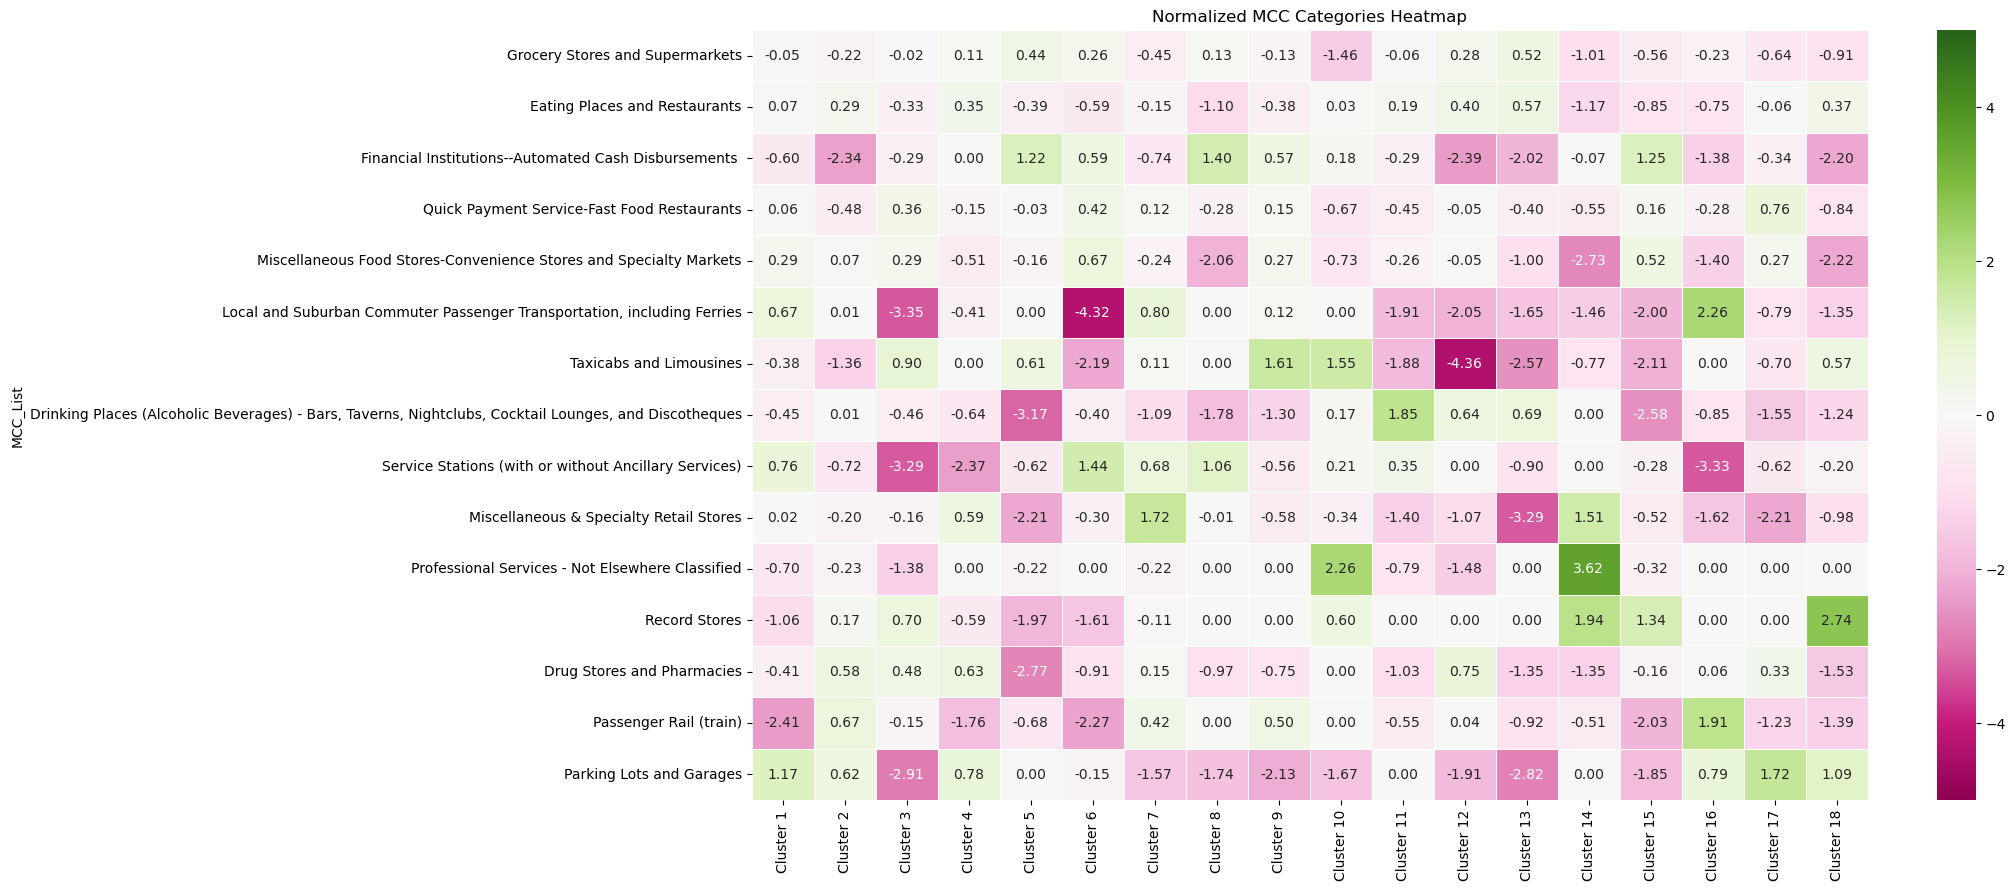

In [243]:
def mcc_heatmap_relative(clusters, df):
    cluster_counts = []
    cluster_counts_relative = []
    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        # calculate tfidf of each MCC
        mcc_counts_normalized = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        mcc_counts_relative = np.log(filtered_df['MCC_List'].value_counts(normalize=True) / df_mcc['proportion']).rename(f'Cluster {i + 1}')
        # mcc_counts_relative = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}') / df_mcc['proportion']
        cluster_counts.append(mcc_counts_normalized)
        cluster_counts_relative.append(mcc_counts_relative)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    mcc_df_relative = pd.concat(cluster_counts_relative, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = mcc_df_normalized.sum(axis=1).nlargest(15).index

    # Filter the DataFrame to keep only the top categories
    mcc_top_df_normalized = mcc_df_relative.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(mcc_top_df_normalized, cmap='PiYG', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    # sns.heatmap(mcc_top_df_normalized, cmap='seismic', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

mcc_heatmap_relative(Customer_clusters, df)

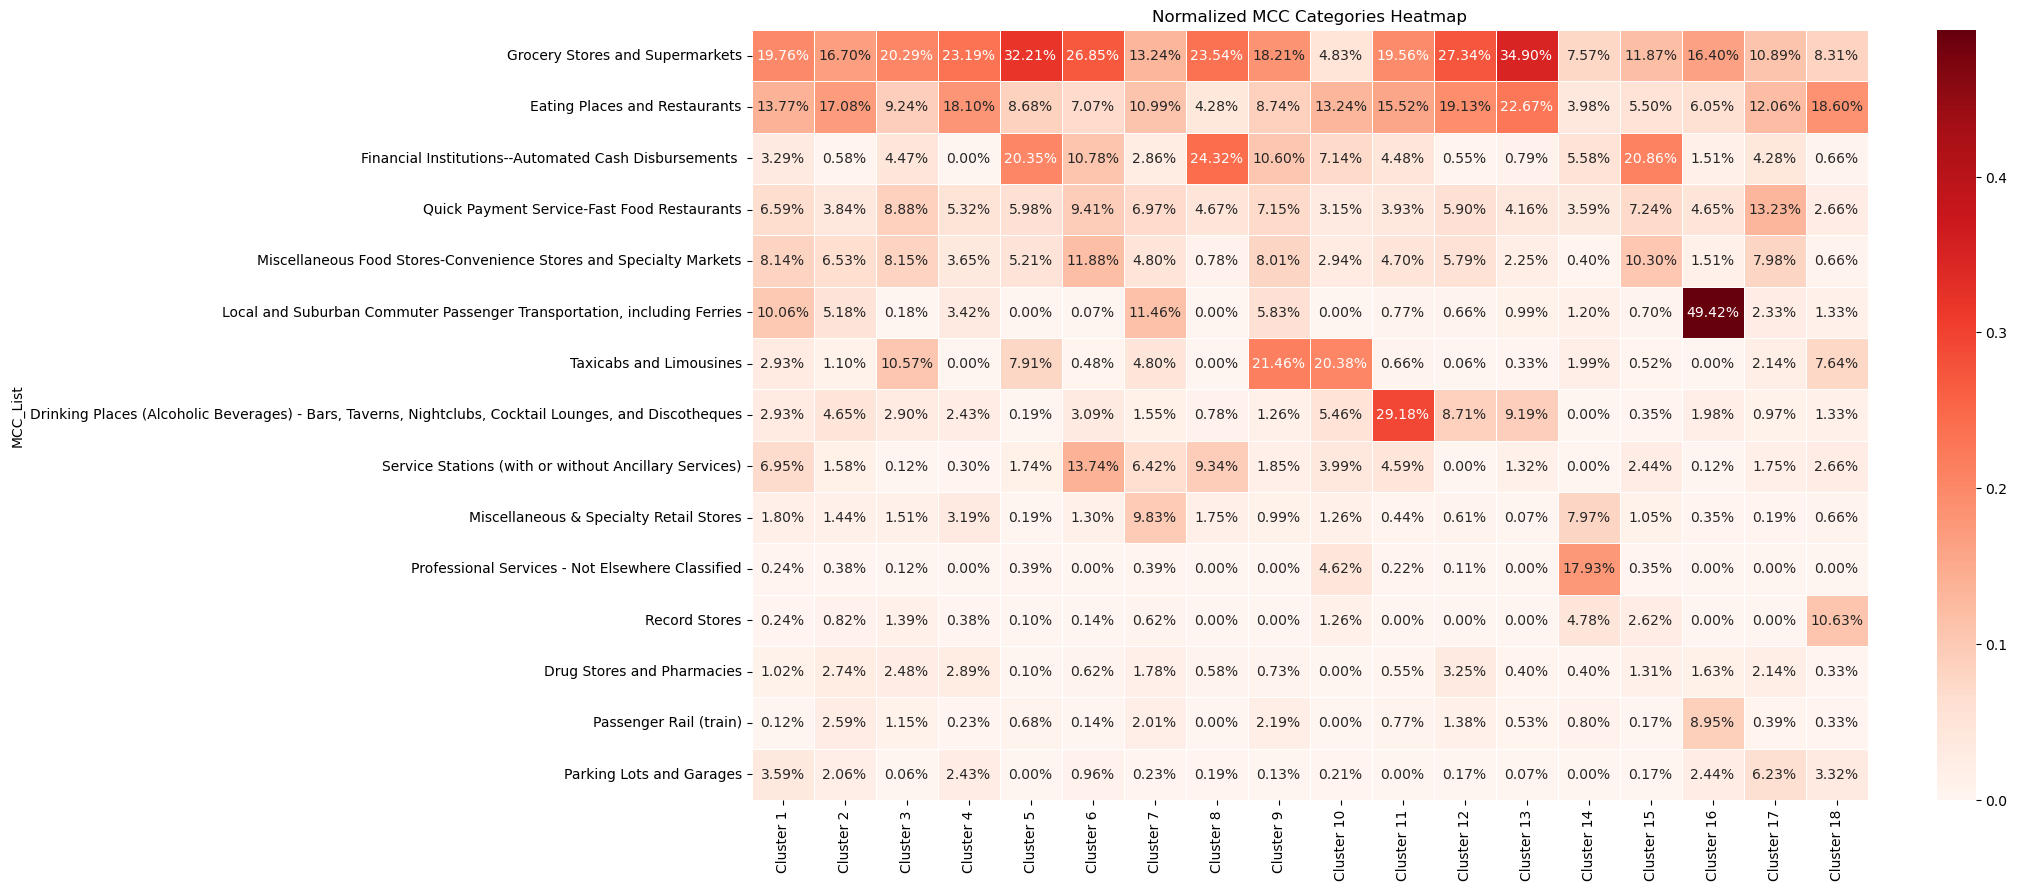

In [244]:
def mcc_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        mcc_counts_normalized = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(mcc_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = mcc_df_normalized.sum(axis=1).nlargest(15).index

    # Filter the DataFrame to keep only the top categories
    mcc_top_df_normalized = mcc_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(mcc_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

mcc_heatmap_normalized(Customer_clusters, df)

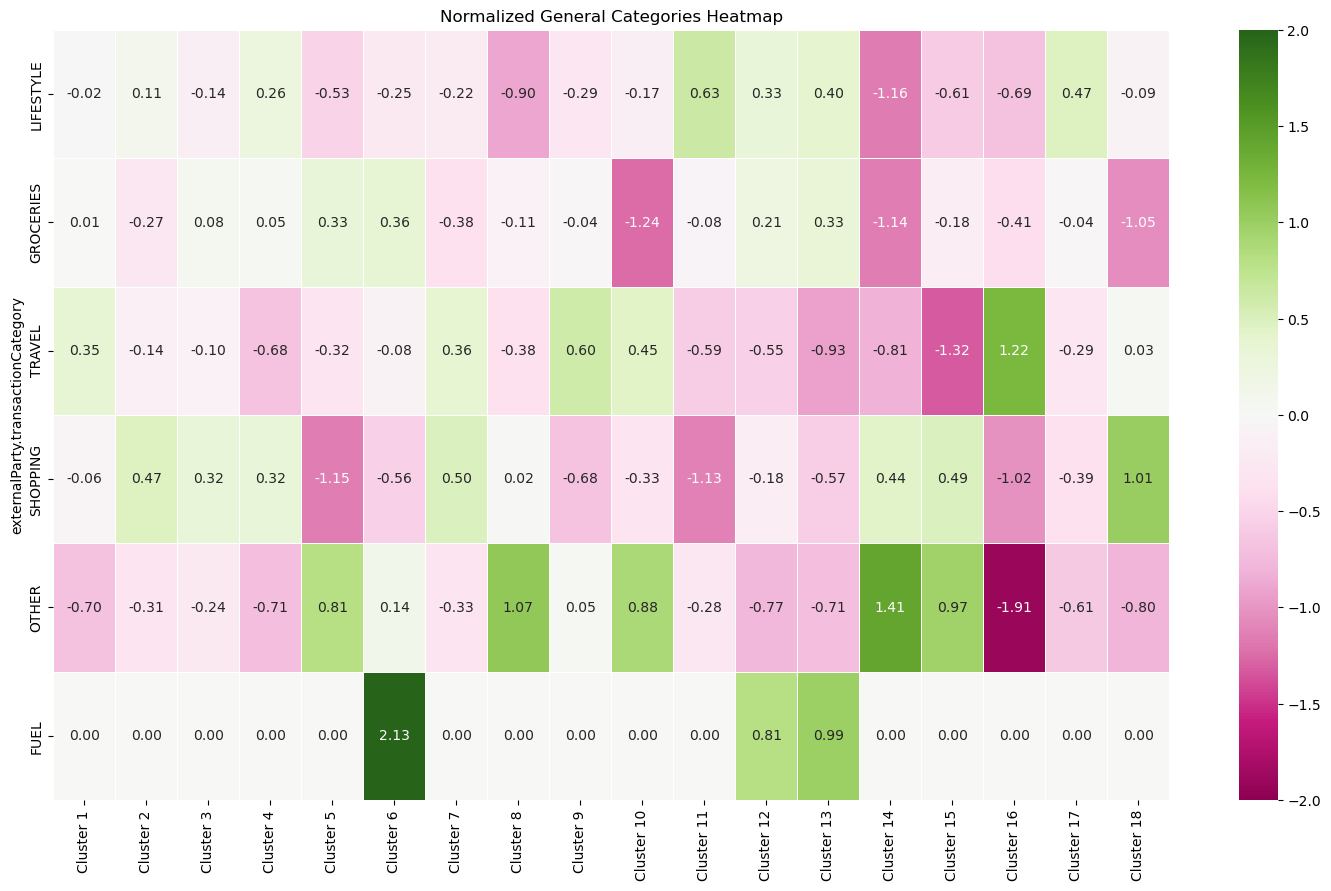

In [245]:
df = filtered_data
def cate_heatmap_relative(clusters, df):
    cluster_counts = []
    cluster_counts_relative = []
    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        cate_counts_normalized = filtered_df['externalParty.transactionCategory'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cate_counts_relative = np.log(filtered_df['externalParty.transactionCategory'].value_counts(normalize=True)/df_category['proportion']).rename(f'Cluster {i + 1}')
        cluster_counts.append(cate_counts_normalized)
        cluster_counts_relative.append(cate_counts_relative)

    # Combine the normalized counts into a single DataFrame
    cate_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    cate_df_relative = pd.concat(cluster_counts_relative, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = cate_df_normalized.sum(axis=1).nlargest(6).index

    # Filter the DataFrame to keep only the top categories
    cate_top_df_normalized = cate_df_relative.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cate_top_df_normalized, cmap='PiYG', annot=True, fmt='.2f', linewidths=.5, vmin=-2, vmax=2)
    plt.title('Normalized General Categories Heatmap')
    plt.show()

cate_heatmap_relative(Customer_clusters, df)

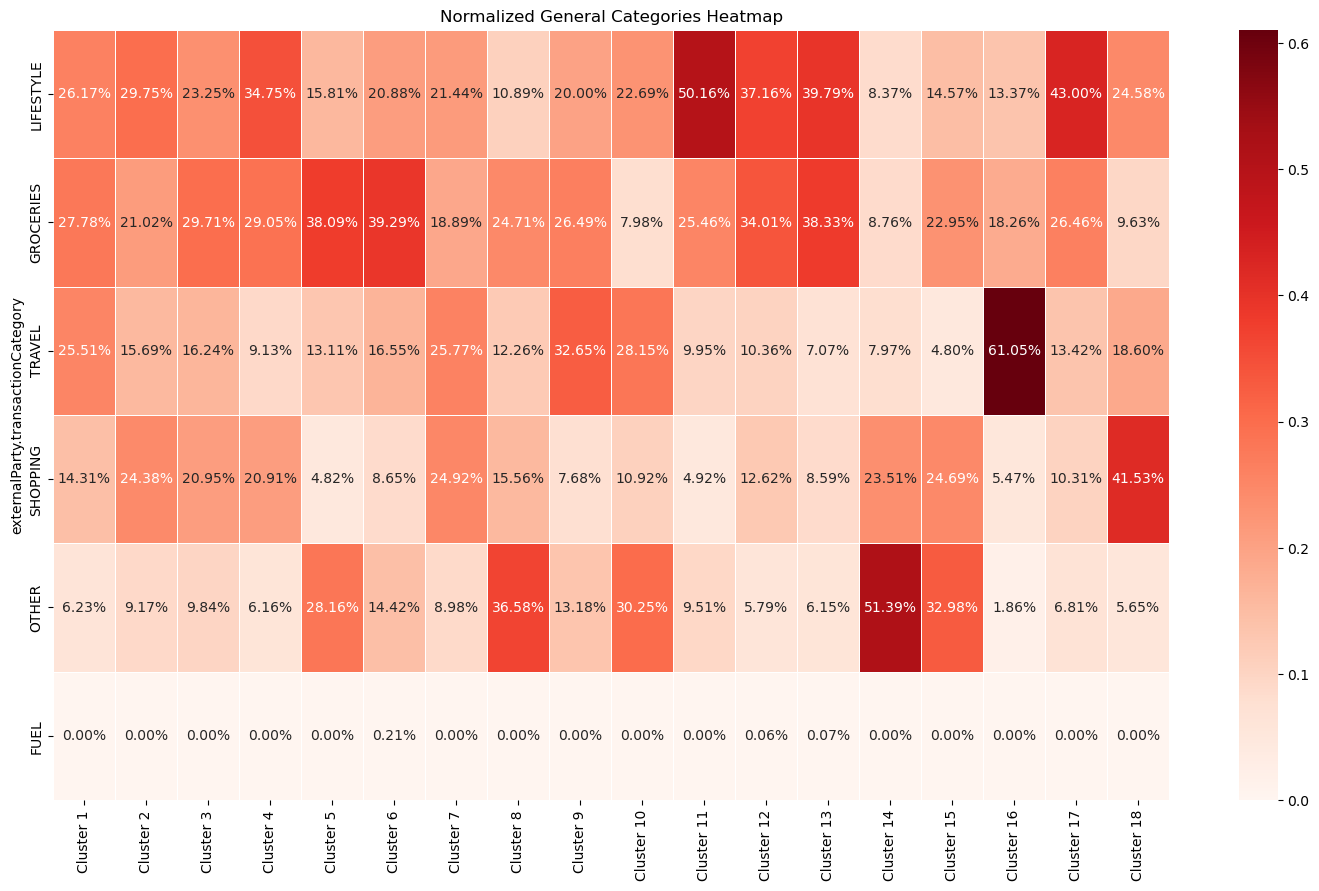

In [246]:
df = filtered_data
def cate_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        cate_counts_normalized = filtered_df['externalParty.transactionCategory'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(cate_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    cate_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = cate_df_normalized.sum(axis=1).nlargest(6).index

    # Filter the DataFrame to keep only the top categories
    cate_top_df_normalized = cate_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cate_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized General Categories Heatmap')
    plt.show()

cate_heatmap_normalized(Customer_clusters, df)

### two-level heatmap

In [247]:
df_clusters

CustomerID  level_0  level_1  level_2   level
0    187bd84b-20c7-45c7-8044-0fdb586e28a1        0        0        0     0_0
1    4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8        0        0        0     0_0
2    0e2674c3-d76c-4b6d-865d-82d246b87f29        7        0        0     0_7
3    e8de70d9-720e-4c98-bee4-109d48719048        7        0        0     0_7
4    1abbb4da-f42b-473b-847a-52bfabcd4db1        7        0        0     0_7
..                                    ...      ...      ...      ...     ...
364  3408c175-ea12-456f-9ef9-c470d785b4c1       61       17        3   17_61
365  fb76a679-f1f5-44d0-81fd-69059c63167d       66       17        3   17_66
366  ff6ef7e8-4b43-44f7-a1ef-7d35407c2219       66       17        3   17_66
367  49a82fdf-205d-42c2-b3a3-13cb47d335fc       66       17        3   17_66
368  e9ce12f2-9112-415a-a6fd-b72f0bcc83ec      101       17        3  17_101

[369 rows x 5 columns]

In [248]:
filtered_data['level'] = filtered_data['customerId'].map(df_clusters.set_index('CustomerID')['level'])
filtered_data['cate_mcc'] = filtered_data['externalParty.transactionCategory'] + '_' + filtered_data['MCC_List']

In [249]:
filtered_data.head()

_id                 accountId  \
0  6220c8e159378700114a8722  61c5e725941a0600135559cf   
1  62c30db86daa10001266325e  6215fbb82c463a001166ad8f   
2  62e0fcf555577b00112d3176  625e873608ff4300110c62af   
4  62c44ba62e447d00129fc612  61c453eebcc5e4001133f68a   
5  62c5589f756f3f00119ec3b4  61c453eebcc5e4001133f68a   

                             customerId IMD_Decile                 createdAt  \
0  4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8          9  2022-03-03T13:55:45.434Z   
1  a4c47159-e445-4b31-8ea9-6c5852bd7095          8  2022-07-04T15:56:40.950Z   
2  b5a28615-7994-458e-8903-8086ac77eb49  Not_Found  2022-07-27T08:53:09.433Z   
4  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-05T14:33:10.080Z   
5  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-06T09:40:47.483Z   

  amount.currency  amount.exponent  amount.value  \
0             GBP                2          5067   
1             GBP                2          4600   
2             GBP                2          5000   
4             GBP                2           600   
5             GBP                2           600   

   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 742                             OTHER   
2                                 742                             OTHER   
4                                1520                          SHOPPING   
5                                1520                          SHOPPING   

                                  MCC_List  \
0                      Veterinary Services   
1                      Veterinary Services   
2                      Veterinary Services   
4  General Contractor/Residential Building   
5  General Contractor/Residential Building   

   transactionFootPrint.carbonEmissionInGrams transactionType.code  \
0                                10048.033278           REDEMPTION   
1                                 9121.956400           REDEMPTION   
2                                 9915.170000           REDEMPTION   
4                                15224.930000           REDEMPTION   
5                                15224.930000           REDEMPTION   

  transactionType.direction  emission_rate     mcc_classification level  \
0                     DEBIT       1.944456  Agricultural Services   0_0   
1                     DEBIT       1.983033  Agricultural Services   1_1   
2                     DEBIT       1.983034  Agricultural Services   2_2   
4                     DEBIT      25.374883    Contracted Services   3_3   
5                     DEBIT      25.374883    Contracted Services   3_3   

                                           cate_mcc  
0                         OTHER_Veterinary Services  
1                         OTHER_Veterinary Services  
2                         OTHER_Veterinary Services  
4  SHOPPING_General Contractor/Residential Building  
5  SHOPPING_General Contractor/Residential Building

In [250]:
df_catemcc = filtered_data.groupby('cate_mcc')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_catemcc['idf'] = np.log(len(CustomerID)/df_catemcc['nunique_customers'])
df_catemcc = df_catemcc.set_index('cate_mcc')
df_catemcc['proportion'] = filtered_data['cate_mcc'].value_counts(normalize=True)
df_catemcc

nunique_customers  \
cate_mcc                                                                
GROCERIES_Grocery Stores and Supermarkets                         312   
LIFESTYLE_Eating Places and Restaurants                           281   
LIFESTYLE_Quick Payment Service-Fast Food Resta...                262   
GROCERIES_Miscellaneous Food Stores-Convenience...                234   
OTHER_Financial Institutions--Automated Cash Di...                193   
...                                                               ...   
OTHER_Laundry Services - Family and Commercial                      1   
OTHER_Miscellaneous Repair Shops and Related Se...                  1   
OTHER_Heating, Plumbing, Air Conditioning Contr...                  1   
TRAVEL_Miscellaneous Automotive, Aircraft, and ...                  1   
LIFESTYLE_Aquarium, Seaquarium, Dolphinariums                       1   

                                                         idf  proportion  
cate_mcc                                                                  
GROCERIES_Grocery Stores and Supermarkets           0.167793    0.203159  
LIFESTYLE_Eating Places and Restaurants             0.272442    0.125713  
LIFESTYLE_Quick Payment Service-Fast Food Resta...  0.342452    0.061454  
GROCERIES_Miscellaneous Food Stores-Convenience...  0.455476    0.059585  
OTHER_Financial Institutions--Automated Cash Di...  0.648106    0.059732  
...                                                      ...         ...  
OTHER_Laundry Services - Family and Commercial      5.910797    0.000148  
OTHER_Miscellaneous Repair Shops and Related Se...  5.910797    0.000049  
OTHER_Heating, Plumbing, Air Conditioning Contr...  5.910797    0.000049  
TRAVEL_Miscellaneous Automotive, Aircraft, and ...  5.910797    0.000049  
LIFESTYLE_Aquarium, Seaquarium, Dolphinariums       5.910797    0.000049  

[225 rows x 3 columns]

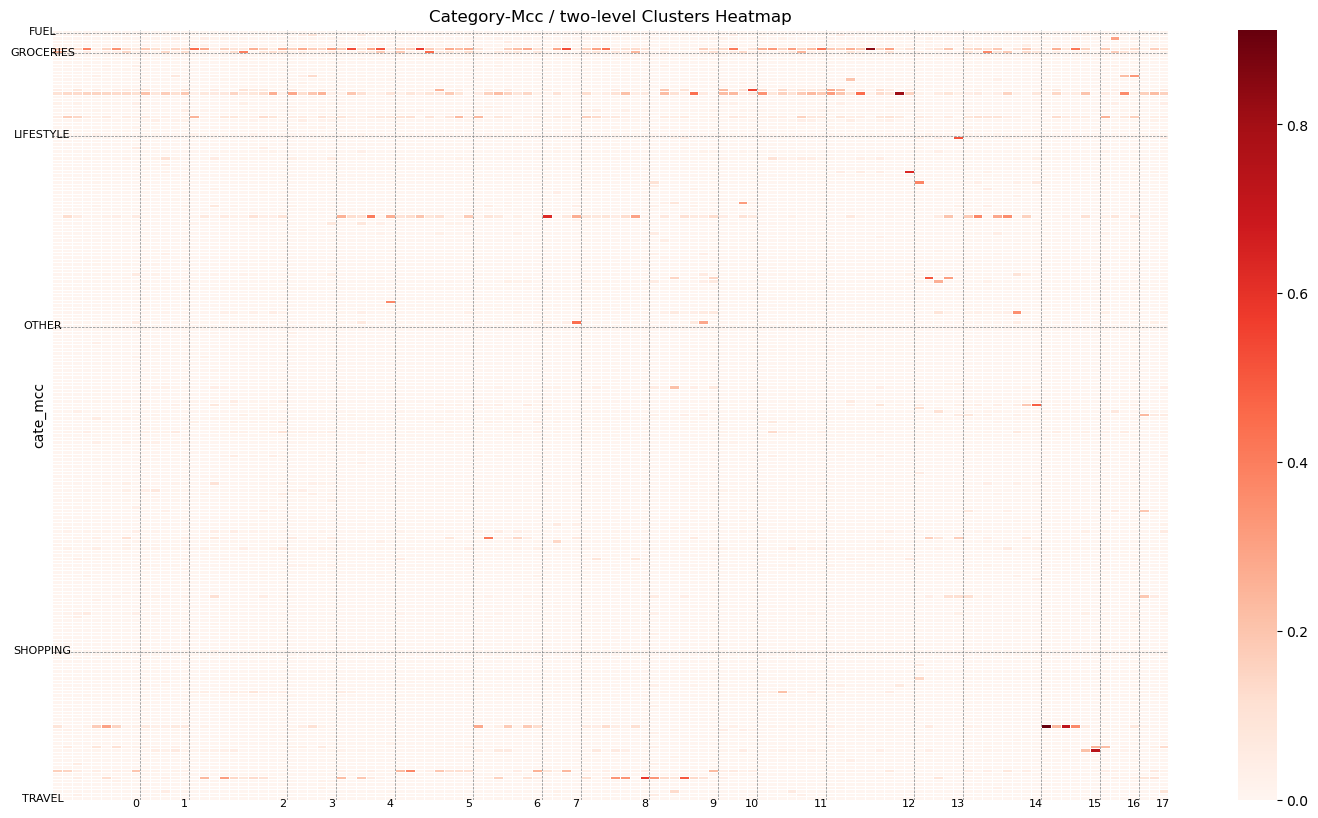

In [262]:
def two_level_heatmap(df_clusters, df, relative=False):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for cluster in df_clusters['level'].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['level']==cluster]
        # calculate tfidf of each MCC
        if relative:
            mcc_counts_normalized = np.log(filtered_df['cate_mcc'].value_counts(normalize=True) / df_catemcc['proportion']).rename(cluster)
        else:
            mcc_counts_normalized = filtered_df['cate_mcc'].value_counts(normalize=True).rename(cluster)
        cluster_counts.append(mcc_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # print(mcc_df_normalized.shape)
    # sort mcc by their category alphabetically
    mcc_df_normalized = mcc_df_normalized.reindex(sorted(mcc_df_normalized.index))
    
    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(mcc_df_normalized, cmap='PiYG', annot=False, fmt='.2f', linewidths=.5, vmin=-5, vmax=5, xticklabels=False, yticklabels=False)
    else:
        sns.heatmap(mcc_df_normalized, cmap='Reds', annot=False, fmt='.2%', linewidths=.5, xticklabels=False, yticklabels=False)
    # sns.heatmap(mcc_top_df_normalized, cmap='seismic', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    # highlight the category boundaries and the cluster boundaries
    for category, y in filtered_data.groupby('externalParty.transactionCategory')['MCC_List'].nunique().sort_index().cumsum().items():
        plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
        plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    for level, x in df_clusters.groupby('level_1')['level_0'].nunique().sort_index().cumsum().items():
        plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
        plt.text(x-0.5, y+1, level, ha='center', va='center', fontsize=8)

    plt.title('Category-Mcc / two-level Clusters Heatmap')
    plt.show()

two_level_heatmap(df_clusters, filtered_data, relative=False)

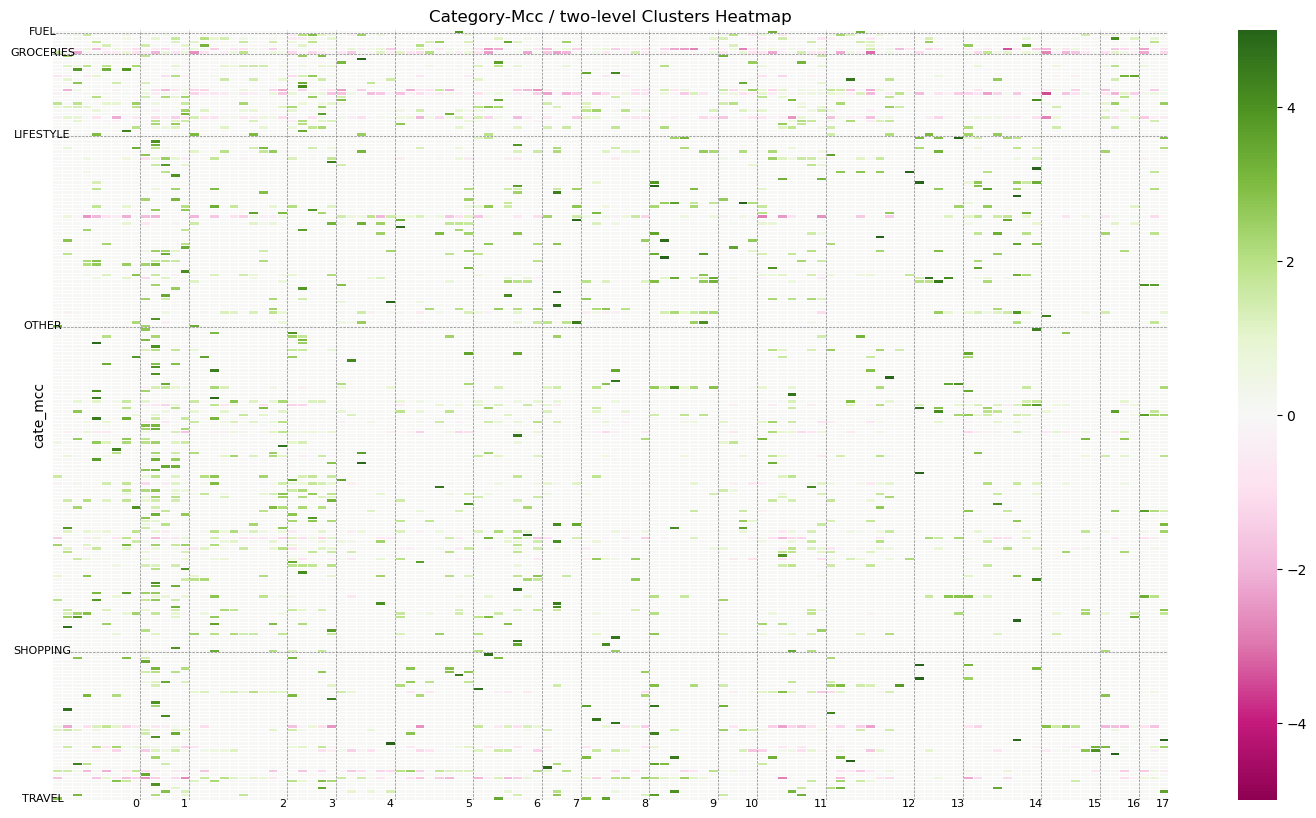

In [263]:
two_level_heatmap(df_clusters, filtered_data, relative=True)

In [264]:
filtered_data['MCC_List'].value_counts()

MCC_List
Grocery Stores and Supermarkets                                       4214
Eating Places and Restaurants                                         2604
Quick Payment Service-Fast Food Restaurants                           1257
Miscellaneous Food Stores-Convenience Stores and Specialty Markets    1240
Financial Institutions--Automated Cash Disbursements                  1218
                                                                      ... 
Stationery, Office Supplies, and Printing and Writing Paper              1
SN Brussels Airlines - SN BRUSSELS                                       1
Tax Payments                                                             1
Heating, Plumbing, Air Conditioning Contractors                          1
Emirates Airlines                                                        1
Name: count, Length: 199, dtype: int64

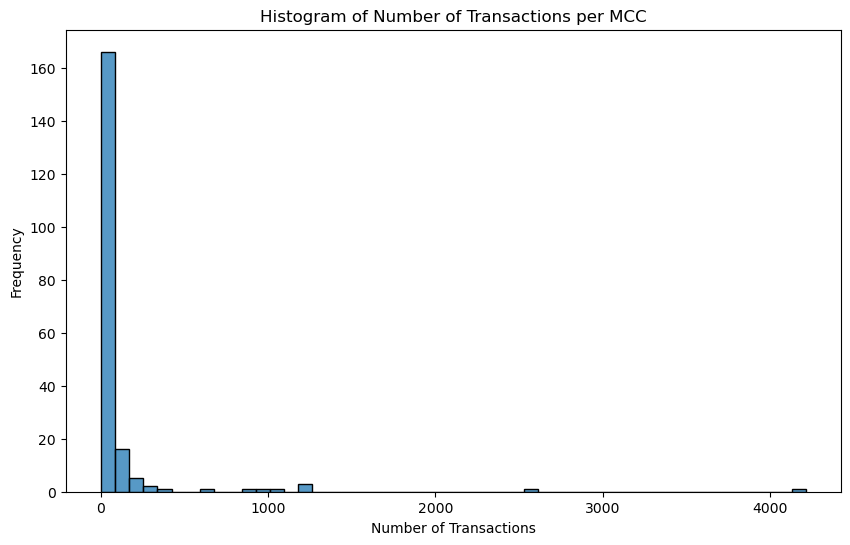

In [265]:
# plot the histogram of the number of transactions per mcc
plt.figure(figsize=(10,6))
sns.histplot(filtered_data['MCC_List'].value_counts(), bins=50)
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Transactions per MCC')
plt.show()

## Carbon emission Analysis

In [217]:
# calculate the average co2 emission per pound and total number of transaction for each customer
result = filtered_data.groupby('customerId').agg(total_co2 = ('transactionFootPrint.carbonEmissionInGrams', 'sum'),total_amount=('amount.value', 'sum'), transaction_count=('customerId', 'size'))
result['average_co2_per_pound'] = result['total_co2'] / result['total_amount']
# normalize the data
result['total_co2'] = (result['total_co2'] - result['total_co2'].mean()) / result['total_co2'].std()
result['total_amount'] = (result['total_amount'] - result['total_amount'].mean()) / result['total_amount'].std()
result['average_co2_per_pound'] = (result['average_co2_per_pound'] - result['average_co2_per_pound'].mean()) / result['average_co2_per_pound'].std()
result['transaction_count'] = (result['transaction_count'] - result['transaction_count'].mean()) / result['transaction_count'].std()
result.head()

total_co2  total_amount  \
customerId                                                      
01968de9-41cb-4509-b0a6-6bdc02700150   1.885294      2.513451   
01b34ce5-ce43-4c2d-a73d-5294376bd399  -0.083921     -0.122645   
01b4698f-32be-4bc0-9b69-b3024ac18004  -0.308146     -0.239822   
01ef943c-d661-48b0-9c0b-bb456a7d998d   0.031179     -0.190149   
03025a2b-9179-4da9-8dff-af4a3179ce7f  -0.074867      0.278659   

                                      transaction_count  average_co2_per_pound  
customerId                                                                      
01968de9-41cb-4509-b0a6-6bdc02700150           3.421743              -0.128694  
01b34ce5-ce43-4c2d-a73d-5294376bd399          -0.490151               0.026886  
01b4698f-32be-4bc0-9b69-b3024ac18004          -0.149342              -0.240190  
01ef943c-d661-48b0-9c0b-bb456a7d998d          -0.223431               0.398112  
03025a2b-9179-4da9-8dff-af4a3179ce7f           0.917538              -0.361719

In [213]:
# create a color map with 9 colors
colors = sns.color_palette('hsv', 9)
# create a color dictionary for the clusters, based on the customer_clusters
cluster_color_dict = {}
for i, cluster in enumerate(Customer_clusters):
    for customer in cluster:
        cluster_color_dict[customer] = colors[i]
cluster_color_dict

{'434a60bb-b98e-47e6-87e1-aa1bd913bde1': (1.0, 0.5790446966917554, 0.0),
 'fccc649d-a523-4f39-bc66-1e46a8ced7e5': (1.0, 0.5790446966917554, 0.0),
 'b88e862d-644e-40f3-af94-049cdb76c52e': (1.0, 0.5790446966917554, 0.0),
 'a3ba222c-b1a7-4686-bb63-539d43797376': (1.0, 0.5790446966917554, 0.0),
 '15182db2-b11c-4143-9dc5-f6ae29713936': (1.0, 0.5790446966917554, 0.0),
 'bfa3923b-5a03-4e9f-8301-7a65e681b068': (1.0, 0.5790446966917554, 0.0),
 '0ae40402-f81b-4ce1-801f-94246b674aef': (1.0, 0.5790446966917554, 0.0),
 '5b808c6c-9bc2-4298-8d4f-c1f4d3e46a95': (1.0, 0.5790446966917554, 0.0),
 '481427cb-72cb-4c84-8f19-03eee1f709b2': (1.0, 0.5790446966917554, 0.0),
 'a63ba1d5-c8ee-408b-ade5-b717cce075af': (1.0, 0.5790446966917554, 0.0),
 '7a2f20ea-5b1f-4582-a831-b6f44f06d148': (1.0, 0.5790446966917554, 0.0),
 'c3924705-b945-49a4-8cfd-00ac0e28b4ff': (1.0, 0.5790446966917554, 0.0),
 'bc417046-068f-49d2-bd29-ae34decc12fd': (1.0, 0.5790446966917554, 0.0),
 'd2f7ab36-24c1-4b3b-9002-8a6c46ae7fe8': (1.0, 0.57

In [218]:
# map the color dictionary to the customer_id in the result dataframe
result['color'] = result.index.map(cluster_color_dict)
result.head()

total_co2  total_amount  \
customerId                                                      
01968de9-41cb-4509-b0a6-6bdc02700150   1.885294      2.513451   
01b34ce5-ce43-4c2d-a73d-5294376bd399  -0.083921     -0.122645   
01b4698f-32be-4bc0-9b69-b3024ac18004  -0.308146     -0.239822   
01ef943c-d661-48b0-9c0b-bb456a7d998d   0.031179     -0.190149   
03025a2b-9179-4da9-8dff-af4a3179ce7f  -0.074867      0.278659   

                                      transaction_count  \
customerId                                                
01968de9-41cb-4509-b0a6-6bdc02700150           3.421743   
01b34ce5-ce43-4c2d-a73d-5294376bd399          -0.490151   
01b4698f-32be-4bc0-9b69-b3024ac18004          -0.149342   
01ef943c-d661-48b0-9c0b-bb456a7d998d          -0.223431   
03025a2b-9179-4da9-8dff-af4a3179ce7f           0.917538   

                                      average_co2_per_pound  \
customerId                                                    
01968de9-41cb-4509-b0a6-6bdc02700150              -0.128694   
01b34ce5-ce43-4c2d-a73d-5294376bd399               0.026886   
01b4698f-32be-4bc0-9b69-b3024ac18004              -0.240190   
01ef943c-d661-48b0-9c0b-bb456a7d998d               0.398112   
03025a2b-9179-4da9-8dff-af4a3179ce7f              -0.361719   

                                                                color  
customerId                                                             
01968de9-41cb-4509-b0a6-6bdc02700150  (0.23970412205706326, 1.0, 0.0)  
01b34ce5-ce43-4c2d-a73d-5294376bd399  (0.14595412205706287, 0.0, 1.0)  
01b4698f-32be-4bc0-9b69-b3024ac18004  (0.14595412205706287, 0.0, 1.0)  
01ef943c-d661-48b0-9c0b-bb456a7d998d   (0.0, 1.0, 0.9647031631761764)  
03025a2b-9179-4da9-8dff-af4a3179ce7f   (0.0, 1.0, 0.3625004724974957)

In [220]:
colors

[(1.0, 0.5790446966917554, 0.0),
 (0.8187488187488188, 1.0, 0.0),
 (0.23970412205706326, 1.0, 0.0),
 (0.0, 1.0, 0.3625004724974957),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.4562523625023627, 1.0),
 (0.14595412205706287, 0.0, 1.0),
 (0.724998818748819, 0.0, 1.0),
 (1.0, 0.0, 0.6727946966917553)]

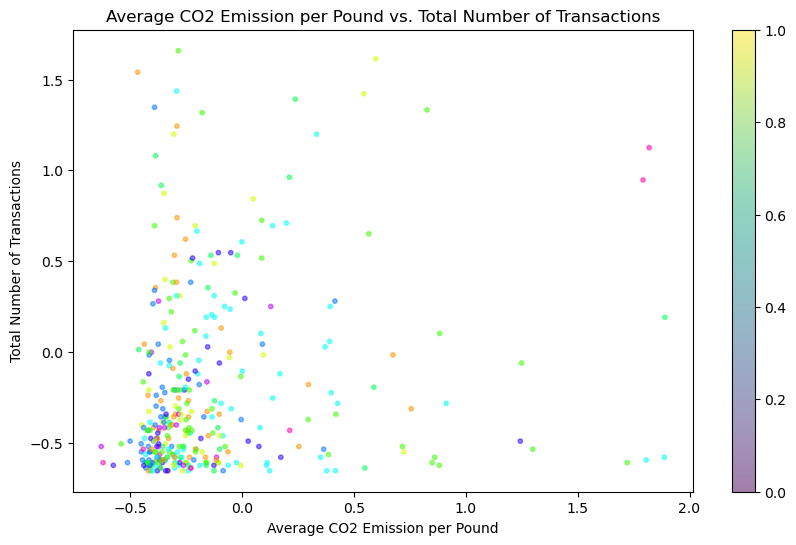

In [225]:
# plot each customer on a scatter plot with x-axis as the average co2 emission per pound and y-axis as the total number of transaction, color by the cluster
plt.figure(figsize=(10, 6))
# create a scatter plot
df_plot = result[(result['transaction_count'] < 2)&(result['average_co2_per_pound'] < 2)]
plt.scatter(df_plot['average_co2_per_pound'], df_plot['transaction_count'], c=df_plot['color'], alpha=0.5, s=10)
plt.xlabel('Average CO2 Emission per Pound')
plt.ylabel('Total Number of Transactions')
plt.title('Average CO2 Emission per Pound vs. Total Number of Transactions')
plt.colorbar()
plt.show()